In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import testStreamingSvd
import streamingSvd as algo

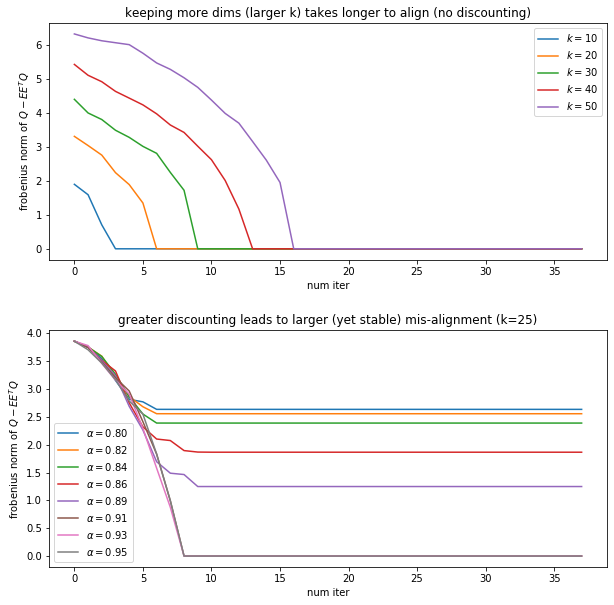

In [2]:
# experiment 6.1 part 1 from john's notes - TODO: comparisons to other methods

# formalizing the lag analysis - question about what E should look like
# xt=a1cos(ω1t)e1 + a2cos(ω2t) (cos(ωst)e2+ sin(ωst)e3)
a1, a2 = 1, 2
om1, om2, oms = 4, 1, .001

num_steps = 1000
n_dims = 3
embed_dim = 50



def slowly_changing_basis(num_steps, e1, e2, e3, noisesig=0):
    xs = np.zeros((e1.shape[0], num_steps))
    n = np.copy(xs)
    for t in range(num_steps):
        n[:, t] = -np.sin(oms*t)*e2 + np.cos(oms*t)*e3
        noisevec = np.random.normal(loc=0, scale=noisesig, size=(e1.shape[0],))
        xs[:, t] = a1*np.cos(om1*t)*e1 + a2*np.cos(om2*t) * (np.cos(oms*t)*e2 + np.sin(oms*t)*e3) + noisevec
    return xs, n


E, R = np.linalg.qr(np.random.uniform(size=(n_dims,3)))
# E = np.random.uniform(size=(n_dims, 3))
e1 = E[:, 0]
e2 = E[:, 1]
e3 = E[:, 2]
xs, n = slowly_changing_basis(num_steps, e1, e2, e3, noisesig=10)

# embedding in higher dimensino
embed_mat = np.random.uniform(size=(embed_dim, n_dims))
embed_xs = np.dot(embed_mat, xs)
E = np.dot(embed_mat, E)
E, R = np.linalg.qr(E) 

l1 = 50
l = 25
decay = 1
k_range = np.arange(10, 60, 10)
num_iters = np.ceil((embed_xs.shape[1] - l1) / l).astype('int')
Q_recon_diff = np.zeros((k_range.shape[0], num_iters))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'hspace':.3})
for i in range(k_range.shape[0]):
    k = k_range[i]
    Qtcoll, S, Qcoll = algo.getSvd(embed_xs, k, l1, l, num_iters, decay_alpha=decay)
    for j in range(num_iters):
        currQ = Qcoll[:, :, j]
        tmp =  (currQ - E.dot(E.T).dot(currQ))
        Q_recon_diff[i, j] = np.linalg.norm(tmp)
    ax1.plot(Q_recon_diff[i, :].T, label=r'$k = $' + '{}'.format(k))

ax1.set(xlabel='num iter', ylabel='frobenius norm of ' + r'$Q - EE^{T}Q$', 
       title='keeping more dims (larger k) takes longer to align (no discounting)')
ax1.legend()

# ----------------------------------------------------------------- #

k = 25
decay_range = np.linspace(.8, .95, num=8)
Q_recon_diff = np.zeros((decay_range.shape[0], num_iters))
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
for i in range(decay_range.shape[0]):
    decay = decay_range[i]
    Qtcoll, S, Qcoll = algo.getSvd(embed_xs, k, l1, l, num_iters, decay_alpha=decay)
    for j in range(num_iters):
        currQ = Qcoll[:, :, j]
        tmp =  (currQ - E.dot(E.T).dot(currQ))
        Q_recon_diff[i, j] = np.linalg.norm(tmp)
    ax2.plot(Q_recon_diff[i, :].T, label=r'$\alpha = $' + '{0:.2f}'.format(decay))

ax2.set(xlabel='num iter', ylabel='frobenius norm of ' + r'$Q - EE^{T}Q$', 
       title='greater discounting leads to larger (yet stable) mis-alignment (k=25)')
ax2.legend()

# plt.savefig('Q_alignment_to_ground.png', bbox_inches='tight') 

KeyboardInterrupt: 

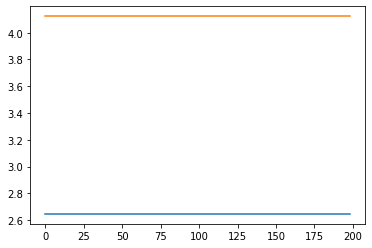

In [3]:
# same example as above, using regular svd - TODO: MAKE THIS WORK
# (doing regular svd of all available cols every iter)

E, R = np.linalg.qr(np.random.uniform(size=(n_dims,3)))
# E = np.random.uniform(size=(n_dims, 3))
e1 = E[:, 0]
e2 = E[:, 1]
e3 = E[:, 2]
xs, n = slowly_changing_basis(num_steps, e1, e2, e3, noisesig=10)

embed_mat = np.random.uniform(size=(embed_dim, n_dims))
embed_xs = np.dot(embed_mat, xs)
E = np.dot(embed_mat, E)
E, R = np.linalg.qr(E) # embedding lower dim E doesn't preserve orthonormality - just doing QR on it?

k_range = np.arange(10, 60, 10)
l = 5
t = 0
num_iters = np.ceil((embed_xs.shape[1] - l) / l).astype('int')
U_recon_diff = np.zeros((k_range.shape[0], num_iters))
fig, ax1 = plt.subplots(1,1)
for i in range(k_range.shape[0]):
    k = k_range[i]
    for j in range(num_iters):
        U, S, V_T = np.linalg.svd(embed_xs[:, :t+l])
        t = t + l
        currU = U[:, :k]
        tmp =  (currU - E.dot(E.T).dot(currU))
        U_recon_diff[i, j] = np.linalg.norm(tmp)
    ax1.plot(U_recon_diff[i, :].T, label=r'$k = $' + '{}'.format(k))
ax1.set(xlabel='num iter', ylabel='frobenius norm of ' + r'$U - EE^{T}U$', 
       title='')
ax1.legend()

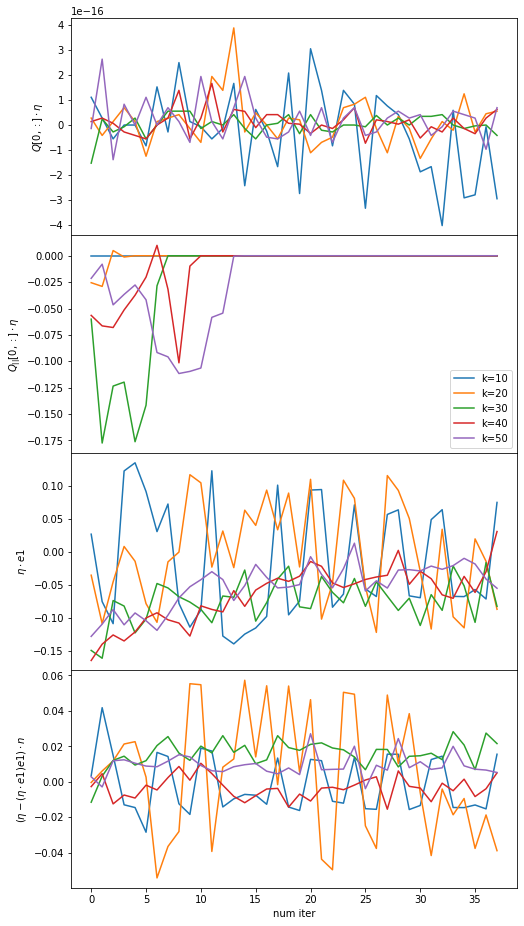

In [5]:
# experiment 6.1 part 2 - TODO: comparisons with other methods (regular svd to start)

a1, a2 = 1, 2
om1, om2, oms = 4, 1, .0001
num_steps = 1000
n_dims = 50
embed_dim = 50

E, R = np.linalg.qr(np.random.uniform(size=(n_dims,3)))
# E = np.random.uniform(size=(n_dims, 3))
e1 = E[:, 0]
e2 = E[:, 1]
e3 = E[:, 2]
xs, n = slowly_changing_basis(num_steps, e1, e2, e3, noisesig=0)

embed_mat = np.random.uniform(size=(embed_dim, n_dims))
embed_xs = np.dot(embed_mat, xs)
E = np.dot(embed_mat, E)
E, R = np.linalg.qr(E)

l1 = 50
l = 25
decay = 1
k_range = np.arange(10, 60, 10)
num_iters = np.ceil((embed_xs.shape[1] - l1) / l).astype('int')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8, 16), sharex=True, gridspec_kw={'hspace':0})
for j in range(k_range.shape[0]):
    k = k_range[j]
    Qtcoll, S, Qcoll = algo.getSvd(embed_xs, k, l1, l, num_iters, decay_alpha=decay)
    Qprojeta = np.zeros((10, Qcoll.shape[2]))
    Qeta = np.copy(Qprojeta)
    etae1 = np.zeros((Qcoll.shape[2]))
    ang_around_axis = np.zeros((Qcoll.shape[2]))
    for i in range(Qcoll.shape[2]):
        Q = Qcoll[:, :10, i]
        Z = scipy.linalg.null_space(Q.T)
        eta = Z[:, 0]
        Qproj = E.dot(E.T).dot(Q)
        Qprojeta[:, i] = Qproj.T.dot(eta)
        Qeta[:, i] = Q.T.dot(eta)
        etae1[i] = np.dot(eta, e1)
        ang_around_axis[i] = ((eta - np.dot(eta, e1)) * e1).dot(n[:, i])

    ax2.plot(Qprojeta[0, :], label='k={}'.format(k))
    ax1.plot(Qeta[0, :])
    ax3.plot(etae1)
    ax4.plot(ang_around_axis)

ax2.set(ylabel=r'$Q_{||}[0,:] \cdot \eta $')
ax1.set(ylabel=r'$Q[0,:] \cdot \eta$')
ax3.set(ylabel=r'$\eta \cdot e1$')
ax4.set(xlabel='num iter', ylabel=r'$(\eta - (\eta \cdot e1)e1) \cdot n$')

ax2.legend()
# plt.savefig('Q_lag_to_ground.png', bbox_inches='tight')

Text(0, 0.5, "fro norm of $(I - Q(t\\')Q(t\\')^T)Q(t)$")

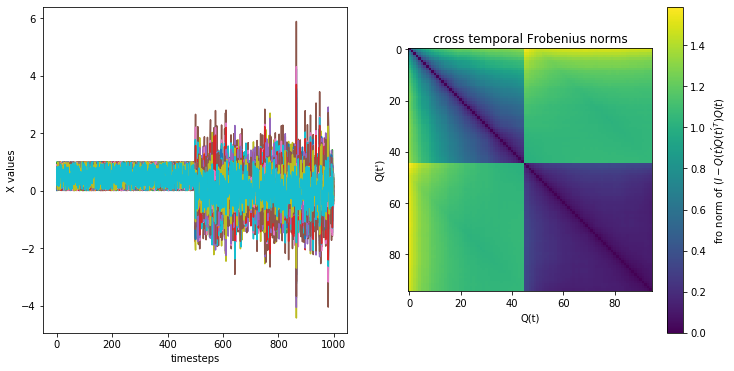

In [6]:
# experiment 6.2 - TODO: NOT WORKING, generate change in sing vals differently

# flipping singular vals - question about the shapes (doing not real svd now)
# try determinant instead of fro norm
# check power
num_steps = 500
n_dims = 50

A = np.random.uniform(size=(n_dims, num_steps))
U, S, V_T = np.linalg.svd(A, full_matrices=False)

X1 = U.dot(np.diag(S)).dot(V_T)
X2 = U.dot(np.diag(np.flip(S))).dot(V_T)
X = np.append(X1, X2, axis=1)

k = 10
l1 = 50
l = 10
decay = 1

num_iters = np.ceil((X.shape[1] - l1) / l).astype('int')
Qtcoll, S, Qcoll = algo.getSvd(X, k, l1, l, num_iters, decay_alpha=decay)

cross_temp_norms = np.zeros((num_iters, num_iters))
for i in range(num_iters):
    for j in range(num_iters):
        Qprime = Qcoll[:, :, i]
        Q = Qcoll[:, :, j]
        tmp = (np.identity(n_dims) - Qprime.dot(Qprime.T)).dot(Q)
        cross_temp_norms[i, j] = np.linalg.norm(tmp)

fig, (ax2, ax3) =plt.subplots(1, 2, figsize=(12,6))
# gs=gridspec.GridSpec(2,3)

# ax1 = fig.add_subplot(gs[0,0])
# ax1.plot(ss[0,:], label='lambda1')
# ax1.plot(ss[1,:], label='lambda2')
# ax1.legend()
# ax1.set(ylabel='singular values')

# ax2 = fig.add_subplot(gs[1,0])
ax2.plot(X.T)
ax2.set(xlabel='timesteps', ylabel='X values')

# ax3 = fig.add_subplot(gs[0:, 1:])
im = ax3.imshow(cross_temp_norms)
ax3.set(xlabel='Q(t)', ylabel='Q(t\')', title='cross temporal Frobenius norms')
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('fro norm of ' + r'$(I - Q(t\')Q(t\')^T)Q(t)$')#, rotation=270)
# sum j lambda_j * u_j * v_j
# sum j u_j * (lambda_j * v_j)

# plt.savefig('Q_flipping_svs.png', bbox_inches='tight')

In [7]:
# WARNING 3D GRAPHICS INCOMING
# visualizing subspace transitioning to orthogonal subspace 
# and our algo's catching up to it
num_pointsA = 200
num_pointsB = 1 * num_pointsA
unif_lim = 1
noise_sig = 0.01

plane_axA = np.random.normal(loc=0, scale=noise_sig, size=(1,num_pointsA))
A = np.random.uniform(-unif_lim, unif_lim, size=(2,num_pointsA))
A = np.insert(A, 1, plane_axA, axis=0)
plane_axB = np.random.normal(loc=0, scale=noise_sig, size=(1,num_pointsB))
B = np.random.uniform(-unif_lim, unif_lim, size=(2,num_pointsB))
B = np.insert(B, 0, plane_axB, axis=0)
Atot = np.append(A, B, axis=1)
# Atot = np.stack((A,B), 2).reshape(A.shape[0], -1)  # mixing up order

k = 2
l1 = 200
l = 5
decay = .95

num_iters = np.ceil((Atot.shape[1] - l1) / l).astype('int')
Qtcoll, S, Qcoll = algo.getSvd(Atot, k, l1, l, num_iters, decay_alpha=decay)

%matplotlib qt5
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax_lim = np.max(np.abs(Atot))
ax1.set(xlim=(-ax_lim, ax_lim), ylim=(-ax_lim, ax_lim), zlim=(-ax_lim, ax_lim))
planeA = Atot[:, :num_pointsA]
planeB = Atot[:, num_pointsA:]
ax1.scatter(planeA[0,:], planeA[1,:], planeA[2,:], alpha=.4, 
            label='first {} cols'.format(num_pointsA))
ax1.scatter(planeB[0,:], planeB[1,:], planeB[2,:], alpha=.4, 
            label='last {} cols'.format(num_pointsB))
ax1.legend()

orig = np.zeros((3,1))
colors = np.zeros((num_iters, 3))
colors[:, 0] = np.arange(0, 1, 1/num_iters)
colors[:, 2] = np.arange(0, 1, 1/num_iters)
for i in range(Qcoll.shape[2]):
    Q = Qcoll[:, :, i]
    ax1.quiver(*orig, Q[0,:], Q[1,:], Q[2,:], color=colors[i, :])


ax2 = fig.add_subplot(122)
Qvecs = Qcoll[:, 0, :]
Qvecs_dists = Qvecs[:, 1:] - Qvecs[:, :-1]
Qvecs_dists = np.linalg.norm(Qvecs_dists, axis=0)
ax2.plot(Qvecs_dists, label='1st SS basis vecs')

Qvecs = Qcoll[:, 1, :]
Qvecs_dists = Qvecs[:, 1:] - Qvecs[:, :-1]
Qvecs_dists = np.linalg.norm(Qvecs_dists, axis=0)
ax2.plot(Qvecs_dists, label='2nd SS basis vecs')
ax2.set(xlabel='iter (each iter adds {} cols of A)'.format(l), 
        ylabel='distance between subsequent singular subspace basis vecs', 
        title='subspace rotation \"inertia\" (decay={:.2f})'.format(decay))
ax2.legend()